# Prosjekt del 1

### Importering av nødvendig bibliotek

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

from sklearn.linear_model import Lasso
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder

from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline

### Innlesing av Data

In [2]:
# lese inn data om oppholdslengde på sykehus
df_hospital = pd.read_csv("hospital.csv")
df_hospital.head()

,pasient_id,sykehusdød,oppholdslengde
0,2,1,4
1,3,0,17
2,4,0,3
3,5,0,-99
4,6,1,4


In [3]:
# data beskrivelse
beskrivelse = df_hospital.describe(include = "all")
beskrivelse

,pasient_id,sykehusdød,oppholdslengde
count,7740.000000,7740.000000,7740.000000
mean,4540.665375,0.263178,17.728682
std,2636.463416,0.440387,21.995401
min,2.000000,0.000000,-99.000000
25%,2244.750000,0.000000,6.000000
50%,4539.500000,0.000000,11.000000
75%,6816.250000,1.000000,20.000000
max,9105.000000,1.000000,343.000000


In [4]:
# lese inn demografisk data
df_demographic = pd.read_csv("demographic.csv")
df_demographic.head()

,pasient_id,alder,kjønn,utdanning,inntekt,etnisitet
0,2,60.33899,female,12.0,$11-$25k,white
1,3,52.74698,female,12.0,under $11k,white
2,4,42.38498,female,11.0,under $11k,white
3,5,79.88495,female,NaN,NaN,white
4,6,93.01599,male,14.0,NaN,white


In [5]:
# data beskrivelse demografi
beskrivelse = df_demographic.describe(include = "all")
beskrivelse

,pasient_id,alder,kjønn,utdanning,inntekt,etnisitet
count,7742.000000,7742.000000,7742,6360.000000,5223,7705
unique,NaN,NaN,2,NaN,4,5
top,NaN,NaN,male,NaN,under $11k,white
freq,NaN,NaN,4370,NaN,2426,6120
mean,4539.500517,62.710904,NaN,11.752987,NaN,NaN
std,2637.118792,15.688113,NaN,3.458671,NaN,NaN
min,2.000000,-1.000000,NaN,0.000000,NaN,NaN
25%,2243.250000,52.915240,NaN,10.000000,NaN,NaN
50%,4538.500000,65.008000,NaN,12.000000,NaN,NaN
75%,6815.750000,74.131487,NaN,14.000000,NaN,NaN


In [6]:
# lese inn data om alvorlighetsgrad
df_severity = pd.read_json("severity.json")

#Gjør kolonnene om til liste for variabelnavn
severity_var = df_severity.columns.to_list()

#Bruker .explode() for å gjøre variablene fra listen om til hver sin rad
df_severity = df_severity.explode(severity_var[2:])

#Reset_index setter indeksene tilbake til 1,2,3,4 ... etc. helt til venstre
df_severity = df_severity.reset_index(drop = True)

# Flytter pasient_id til å være den første kolonnen
cols = ["pasient_id"] + [col for col in df_severity if col != "pasient_id"]
df_severity = df_severity[cols]

df_severity.head()

,pasient_id,sykdomskategori_id,sykdomskategori,dødsfall,sykdom_underkategori,antall_komorbiditeter,koma_score,adl_pasient,adl_stedfortreder,fysiologisk_score,apache_fysiologisk_score,overlevelsesestimat_2mnd,overlevelsesestimat_6mnd,diabetes,demens,kreft,lege_overlevelsesestimat_2mnd,lege_overlevelsesestimat_6mnd,dnr_status,dnr_dag
0,5,A1s,ARF/MOSF,0,ARF/MOSF w/Sepsis,1,26.0,None,2.0,23.5,30.0,0.634888,0.532959,0,0,no,0.9,0.9,None,None
1,15,A1s,ARF/MOSF,0,ARF/MOSF w/Sepsis,1,26.0,None,None,30.5,39.0,0.590942,0.481995,0,0,no,0.9,0.9,None,None
2,18,A1s,ARF/MOSF,1,ARF/MOSF w/Sepsis,0,26.0,None,0.0,40.296875,58.0,0.212982,0.116989,0,0,no,0.1,0.001,None,None
3,23,A1s,ARF/MOSF,0,ARF/MOSF w/Sepsis,1,0.0,None,5.0,31.699219,42.0,0.650879,0.55188,0,0,no,0.6,0.5,None,None
4,28,A1s,ARF/MOSF,1,MOSF w/Malig,1,26.0,None,2.0,46.796875,85.0,0.021,0.004999,0,0,yes,0.05,0.000125,None,None


In [7]:
#Lese inn data
df_physiological = pd.read_csv("physiological.txt", sep="\t")
df_physiological.head()

,pasient_id,blodtrykk,hvite_blodlegemer,hjertefrekvens,respirasjonsfrekvens,kroppstemperatur,lungefunksjon,serumalbumin,bilirubin,kreatinin,natrium,blod_ph,glukose,blodurea_nitrogen,urinmengde
0,2,43.0,17.097656,112.0,34.0,34.59375,98.00000,NaN,NaN,5.500000,132.0,7.250000,NaN,NaN,NaN
1,3,70.0,8.500000,88.0,28.0,37.39844,231.65625,NaN,2.199707,2.000000,134.0,7.459961,NaN,NaN,NaN
2,4,75.0,9.099609,88.0,32.0,35.00000,NaN,NaN,NaN,0.799927,139.0,NaN,NaN,NaN,NaN
3,5,59.0,13.500000,112.0,20.0,37.89844,173.31250,NaN,NaN,0.799927,143.0,7.509766,NaN,NaN,NaN
4,6,110.0,10.398438,101.0,44.0,38.39844,266.62500,NaN,NaN,0.699951,140.0,7.659180,NaN,NaN,NaN


### Kombinere data til felles DataFrame

In [8]:
# kombinere data
df_combined = pd.merge(df_demographic, df_hospital, on="pasient_id", how="outer")
df_combined.head()

,pasient_id,alder,kjønn,utdanning,inntekt,etnisitet,sykehusdød,oppholdslengde
0,2,60.33899,female,12.0,$11-$25k,white,1,4
1,3,52.74698,female,12.0,under $11k,white,0,17
2,4,42.38498,female,11.0,under $11k,white,0,3
3,4,42.38498,female,11.0,under $11k,white,0,3
4,5,79.88495,female,NaN,NaN,white,0,-99


In [9]:
# kombinere data 2
df_combined_2 = pd.merge(df_combined, df_severity, on="pasient_id", how="outer")
df_combined_2.head()

,pasient_id,alder,kjønn,utdanning,inntekt,etnisitet,sykehusdød,oppholdslengde,sykdomskategori_id,sykdomskategori,...,apache_fysiologisk_score,overlevelsesestimat_2mnd,overlevelsesestimat_6mnd,diabetes,demens,kreft,lege_overlevelsesestimat_2mnd,lege_overlevelsesestimat_6mnd,dnr_status,dnr_dag
0,2,60.33899,female,12.0,$11-$25k,white,1,4,BrY,COPD/CHF/Cirrhosis,...,74.0,0.001,0.0,0,0,no,0.0,0.0,None,None
1,3,52.74698,female,12.0,under $11k,white,0,17,BrY,COPD/CHF/Cirrhosis,...,45.0,0.790894,0.664917,0,0,no,0.75,0.5,None,None
2,4,42.38498,female,11.0,under $11k,white,0,3,ChE,Cancer,...,19.0,0.698975,0.411987,0,0,metastatic,0.9,0.5,None,None
3,4,42.38498,female,11.0,under $11k,white,0,3,ChE,Cancer,...,19.0,0.698975,0.411987,0,0,metastatic,0.9,0.5,None,None
4,5,79.88495,female,NaN,NaN,white,0,-99,A1s,ARF/MOSF,...,30.0,0.634888,0.532959,0,0,no,0.9,0.9,None,None


In [10]:
#Kombinert data fullstendig
df_combined_final = pd.merge(df_combined_2, df_physiological, on = "pasient_id", how = "outer")
df_combined_final

,pasient_id,alder,kjønn,utdanning,inntekt,etnisitet,sykehusdød,oppholdslengde,sykdomskategori_id,sykdomskategori,...,kroppstemperatur,lungefunksjon,serumalbumin,bilirubin,kreatinin,natrium,blod_ph,glukose,blodurea_nitrogen,urinmengde
0,2,60.33899,female,12.0,$11-$25k,white,1,4,BrY,COPD/CHF/Cirrhosis,...,34.59375,98.00000,NaN,NaN,5.500000,132.0,7.250000,NaN,NaN,NaN
1,3,52.74698,female,12.0,under $11k,white,0,17,BrY,COPD/CHF/Cirrhosis,...,37.39844,231.65625,NaN,2.199707,2.000000,134.0,7.459961,NaN,NaN,NaN
2,4,42.38498,female,11.0,under $11k,white,0,3,ChE,Cancer,...,35.00000,NaN,NaN,NaN,0.799927,139.0,NaN,NaN,NaN,NaN
3,4,42.38498,female,11.0,under $11k,white,0,3,ChE,Cancer,...,35.00000,NaN,NaN,NaN,0.799927,139.0,NaN,NaN,NaN,NaN
4,5,79.88495,female,NaN,NaN,white,0,-99,A1s,ARF/MOSF,...,37.89844,173.31250,NaN,NaN,0.799927,143.0,7.509766,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7737,9101,66.07300,male,8.0,NaN,white,0,23,A1s,ARF/MOSF,...,35.69531,280.00000,3.699707,0.399963,1.099854,131.0,7.459961,188.0,21.0,NaN
7738,9102,55.15399,female,11.0,NaN,white,0,29,DWw,Coma,...,38.59375,218.50000,NaN,NaN,5.899414,135.0,7.289062,190.0,49.0,0.0
7739,9103,70.38196,male,NaN,NaN,white,0,8,A1s,ARF/MOSF,...,36.69531,180.00000,NaN,0.399963,2.699707,139.0,7.379883,189.0,60.0,3900.0
7740,9104,47.01999,male,13.0,NaN,white,1,7,A1s,ARF/MOSF,...,36.39844,428.56250,1.199951,0.399963,3.500000,135.0,7.469727,246.0,55.0,NaN


### Undersøker hvor mange manglende verdier det er i hver kolonne

In [11]:
nan_count = df_combined_final.isna().sum()
nan_count

pasient_id                          0
alder                               0
kjønn                               0
utdanning                        1382
inntekt                          2519
etnisitet                          37
sykehusdød                          0
oppholdslengde                      0
sykdomskategori_id                  0
sykdomskategori                     0
dødsfall                            0
sykdom_underkategori                0
antall_komorbiditeter               0
koma_score                          0
adl_pasient                      4799
adl_stedfortreder                2442
fysiologisk_score                   0
apache_fysiologisk_score            0
overlevelsesestimat_2mnd            0
overlevelsesestimat_6mnd            0
diabetes                            0
demens                              0
kreft                               0
lege_overlevelsesestimat_2mnd    1422
lege_overlevelsesestimat_6mnd    1408
dnr_status                       6671
dnr_dag     

### Ser på pasienter med negativ oppholdslengde - data som ikke gir mening

In [12]:
invalid_values = df_combined_final[df_combined_final["oppholdslengde"] < 0]
invalid_values

,pasient_id,alder,kjønn,utdanning,inntekt,etnisitet,sykehusdød,oppholdslengde,sykdomskategori_id,sykdomskategori,...,kroppstemperatur,lungefunksjon,serumalbumin,bilirubin,kreatinin,natrium,blod_ph,glukose,blodurea_nitrogen,urinmengde
4,5,79.88495,female,NaN,NaN,white,0,-99,A1s,ARF/MOSF,...,37.89844,173.31250,NaN,NaN,0.799927,143.0,7.509766,NaN,NaN,NaN
21,23,49.61298,female,12.0,$25-$50k,white,0,-99,A1s,ARF/MOSF,...,38.89844,200.00000,2.000000,4.099609,0.599976,130.0,7.399414,NaN,NaN,NaN
85,102,72.39697,female,10.0,NaN,black,0,-99,BrY,COPD/CHF/Cirrhosis,...,37.29688,460.00000,NaN,NaN,2.299805,138.0,7.549805,NaN,NaN,NaN
218,256,54.18198,male,17.0,>$50k,white,1,-99,A1s,ARF/MOSF,...,39.50000,90.00000,1.699951,0.500000,1.199951,130.0,7.309570,NaN,NaN,NaN
440,508,63.25000,male,13.0,$25-$50k,asian,0,-99,ChE,Cancer,...,38.00000,NaN,4.599609,0.500000,0.899902,134.0,NaN,NaN,NaN,NaN
6804,8000,82.05298,female,10.0,under $11k,white,0,-99,DWw,Coma,...,39.69531,187.09375,3.299805,0.799927,1.199951,137.0,7.439453,NaN,NaN,NaN


### Fjerner pasienter med negativ lengde og eventuelle duplikater

In [13]:
#Fjerner alle pasienter hvor oppholdslengden er negativ
df_combined_final = df_combined_final[df_combined_final["oppholdslengde"] >= 0]
#Fjerner duplikater
df_combined_final = df_combined_final.drop_duplicates()
#Ser opå de første radene for å se om pasienten med pasient_id 4 er borte og det stemmer
df_combined_final.head()

,pasient_id,alder,kjønn,utdanning,inntekt,etnisitet,sykehusdød,oppholdslengde,sykdomskategori_id,sykdomskategori,...,kroppstemperatur,lungefunksjon,serumalbumin,bilirubin,kreatinin,natrium,blod_ph,glukose,blodurea_nitrogen,urinmengde
0,2,60.33899,female,12.0,$11-$25k,white,1,4,BrY,COPD/CHF/Cirrhosis,...,34.59375,98.00000,NaN,NaN,5.500000,132.0,7.250000,NaN,NaN,NaN
1,3,52.74698,female,12.0,under $11k,white,0,17,BrY,COPD/CHF/Cirrhosis,...,37.39844,231.65625,NaN,2.199707,2.000000,134.0,7.459961,NaN,NaN,NaN
2,4,42.38498,female,11.0,under $11k,white,0,3,ChE,Cancer,...,35.00000,NaN,NaN,NaN,0.799927,139.0,NaN,NaN,NaN,NaN
5,6,93.01599,male,14.0,NaN,white,1,4,DWw,Coma,...,38.39844,266.62500,NaN,NaN,0.699951,140.0,7.659180,NaN,NaN,NaN
6,7,62.37097,male,14.0,$25-$50k,white,0,9,BrY,COPD/CHF/Cirrhosis,...,37.39844,309.50000,4.799805,0.399963,1.599854,132.0,7.479492,NaN,NaN,NaN


In [52]:
# Fjerner kolonner med mer enn 30% manglende verdier
df_combined_final = df_combined_final.dropna(thresh=df_combined_final.shape[0] * 0.3, axis=1)

# (Valgfritt) Sjekk størrelsen på den nye DataFrame
print("Ny størrelse på df_combined_final:", df_combined_final.shape)
df_combined_final.head()

Ny størrelse på df_combined_final: (7734, 36)


,pasient_id,alder,kjønn,sykehusdød,oppholdslengde,sykdomskategori_id,sykdomskategori,dødsfall,sykdom_underkategori,antall_komorbiditeter,...,kroppstemperatur,lungefunksjon,serumalbumin,bilirubin,kreatinin,natrium,blod_ph,glukose,blodurea_nitrogen,urinmengde
0,2,60.33899,female,1,4,BrY,COPD/CHF/Cirrhosis,1,Cirrhosis,2,...,34.59375,98.00000,NaN,NaN,5.500000,132.0,7.250000,NaN,NaN,NaN
1,3,52.74698,female,0,17,BrY,COPD/CHF/Cirrhosis,1,Cirrhosis,2,...,37.39844,231.65625,NaN,2.199707,2.000000,134.0,7.459961,NaN,NaN,NaN
2,4,42.38498,female,0,3,ChE,Cancer,1,Lung Cancer,2,...,35.00000,NaN,NaN,NaN,0.799927,139.0,NaN,NaN,NaN,NaN
5,6,93.01599,male,1,4,DWw,Coma,1,Coma,1,...,38.39844,266.62500,NaN,NaN,0.699951,140.0,7.659180,NaN,NaN,NaN
6,7,62.37097,male,0,9,BrY,COPD/CHF/Cirrhosis,1,CHF,1,...,37.39844,309.50000,4.799805,0.399963,1.599854,132.0,7.479492,NaN,NaN,NaN


In [15]:
nan_count = df_combined_final.isna().sum()
nan_count

pasient_id                          0
alder                               0
kjønn                               0
utdanning                        1380
inntekt                          2516
etnisitet                          37
sykehusdød                          0
oppholdslengde                      0
sykdomskategori_id                  0
sykdomskategori                     0
dødsfall                            0
sykdom_underkategori                0
antall_komorbiditeter               0
koma_score                          0
adl_pasient                      4792
adl_stedfortreder                2440
fysiologisk_score                   0
apache_fysiologisk_score            0
overlevelsesestimat_2mnd            0
overlevelsesestimat_6mnd            0
diabetes                            0
demens                              0
kreft                               0
lege_overlevelsesestimat_2mnd    1419
lege_overlevelsesestimat_6mnd    1405
blodtrykk                           0
hvite_blodle

### Fjerner også etnisitet, inntekt og utdanning da de er urelevant for oppholdslengde

In [16]:
df_combined_final = df_combined_final.drop(columns=["etnisitet", "inntekt", "utdanning"])
df_combined_final.head()

,pasient_id,alder,kjønn,sykehusdød,oppholdslengde,sykdomskategori_id,sykdomskategori,dødsfall,sykdom_underkategori,antall_komorbiditeter,...,kroppstemperatur,lungefunksjon,serumalbumin,bilirubin,kreatinin,natrium,blod_ph,glukose,blodurea_nitrogen,urinmengde
0,2,60.33899,female,1,4,BrY,COPD/CHF/Cirrhosis,1,Cirrhosis,2,...,34.59375,98.00000,NaN,NaN,5.500000,132.0,7.250000,NaN,NaN,NaN
1,3,52.74698,female,0,17,BrY,COPD/CHF/Cirrhosis,1,Cirrhosis,2,...,37.39844,231.65625,NaN,2.199707,2.000000,134.0,7.459961,NaN,NaN,NaN
2,4,42.38498,female,0,3,ChE,Cancer,1,Lung Cancer,2,...,35.00000,NaN,NaN,NaN,0.799927,139.0,NaN,NaN,NaN,NaN
5,6,93.01599,male,1,4,DWw,Coma,1,Coma,1,...,38.39844,266.62500,NaN,NaN,0.699951,140.0,7.659180,NaN,NaN,NaN
6,7,62.37097,male,0,9,BrY,COPD/CHF/Cirrhosis,1,CHF,1,...,37.39844,309.50000,4.799805,0.399963,1.599854,132.0,7.479492,NaN,NaN,NaN


### Fjerner pasienter hvor oppholdslengde mangler

In [17]:
df_combined_final = df_combined_final.dropna(subset=['oppholdslengde'])
df_combined_final.head()

,pasient_id,alder,kjønn,sykehusdød,oppholdslengde,sykdomskategori_id,sykdomskategori,dødsfall,sykdom_underkategori,antall_komorbiditeter,...,kroppstemperatur,lungefunksjon,serumalbumin,bilirubin,kreatinin,natrium,blod_ph,glukose,blodurea_nitrogen,urinmengde
0,2,60.33899,female,1,4,BrY,COPD/CHF/Cirrhosis,1,Cirrhosis,2,...,34.59375,98.00000,NaN,NaN,5.500000,132.0,7.250000,NaN,NaN,NaN
1,3,52.74698,female,0,17,BrY,COPD/CHF/Cirrhosis,1,Cirrhosis,2,...,37.39844,231.65625,NaN,2.199707,2.000000,134.0,7.459961,NaN,NaN,NaN
2,4,42.38498,female,0,3,ChE,Cancer,1,Lung Cancer,2,...,35.00000,NaN,NaN,NaN,0.799927,139.0,NaN,NaN,NaN,NaN
5,6,93.01599,male,1,4,DWw,Coma,1,Coma,1,...,38.39844,266.62500,NaN,NaN,0.699951,140.0,7.659180,NaN,NaN,NaN
6,7,62.37097,male,0,9,BrY,COPD/CHF/Cirrhosis,1,CHF,1,...,37.39844,309.50000,4.799805,0.399963,1.599854,132.0,7.479492,NaN,NaN,NaN


### Bruker OneHotEncoder for å gjøre kategoriske variabler om til numeriske i treningsdata

In [18]:
# Lager OneHotEncoder objekt
encoder = OneHotEncoder(sparse_output=False)

# Spesifiserer de kategoriske kolonnene som skal bli numeriske
categorical_columns = ["sykdomskategori", "sykdom_underkategori", "kjønn", "sykdomskategori_id", "kreft"]

# Bruker OneHotEncoder for å transformere de kategoriske kolonnene
encoded_data = encoder.fit_transform(df_combined_final[categorical_columns])

# Henter ut kolonnenavn for de OneHot-kodede dataene
encoded_columns = encoder.get_feature_names_out(categorical_columns)

# Lager en ny DataFrame for de OneHot-kodede dataene og sikrer at indeksen er den samme som X_train
encoded_df = pd.DataFrame(encoded_data, columns=encoded_columns, index = df_combined_final.index)

# Kombinerer de numeriske variablene fra X_train med de nye OneHot-kodede variablene
df_encoded = pd.concat([df_combined_final.drop(columns=categorical_columns), encoded_df], axis=1)

df_encoded.head()

,pasient_id,alder,sykehusdød,oppholdslengde,dødsfall,antall_komorbiditeter,koma_score,adl_pasient,adl_stedfortreder,fysiologisk_score,...,sykdom_underkategori_MOSF w/Malig,kjønn_female,kjønn_male,sykdomskategori_id_A1s,sykdomskategori_id_BrY,sykdomskategori_id_ChE,sykdomskategori_id_DWw,kreft_metastatic,kreft_no,kreft_yes
0,2,60.33899,1,4,1,2,44.0,None,1.0,52.695312,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,3,52.74698,0,17,1,2,0.0,1.0,0.0,20.5,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,4,42.38498,0,3,1,2,0.0,0.0,0.0,20.097656,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
5,6,93.01599,1,4,1,1,55.0,None,1.0,19.398438,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
6,7,62.37097,0,9,1,1,0.0,0.0,1.0,17.296875,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


### Deler inn i trenings, validerings og testdata

In [19]:
y = df_encoded["oppholdslengde"]
X = df_encoded.drop(["oppholdslengde"],axis=1)

X_train, X_valtest, y_train, y_valtest = train_test_split(X, y, train_size=0.7, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_valtest, y_valtest, test_size=0.5, random_state=42)

In [20]:
X_train.head()

,pasient_id,alder,sykehusdød,dødsfall,antall_komorbiditeter,koma_score,adl_pasient,adl_stedfortreder,fysiologisk_score,apache_fysiologisk_score,...,sykdom_underkategori_MOSF w/Malig,kjønn_female,kjønn_male,sykdomskategori_id_A1s,sykdomskategori_id_BrY,sykdomskategori_id_ChE,sykdomskategori_id_DWw,kreft_metastatic,kreft_no,kreft_yes
6972,8203,74.12500,0,1,3,0.0,None,0.0,21.097656,17.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
5124,6018,65.26495,1,1,5,44.0,None,0.0,46.898438,71.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
7266,8556,71.98395,0,1,3,0.0,None,0.0,20.398438,26.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3687,4320,52.26599,0,0,1,0.0,None,0.0,37.195312,22.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
7579,8922,69.77100,0,0,1,0.0,0.0,0.0,5.599609,9.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


In [21]:
y_train.head()

6972     5
5124     5
7266    45
3687    19
7579     5
Name: oppholdslengde, dtype: int64

In [22]:
df_train = pd.concat([X_train, y_train.reset_index(drop=True)], axis=1)
df_train

,pasient_id,alder,sykehusdød,dødsfall,antall_komorbiditeter,koma_score,adl_pasient,adl_stedfortreder,fysiologisk_score,apache_fysiologisk_score,...,kjønn_female,kjønn_male,sykdomskategori_id_A1s,sykdomskategori_id_BrY,sykdomskategori_id_ChE,sykdomskategori_id_DWw,kreft_metastatic,kreft_no,kreft_yes,oppholdslengde
6972,8203,74.12500,0.0,1,3,0.0,None,0.0,21.097656,17.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,NaN
5124,6018,65.26495,1.0,1,5,44.0,None,0.0,46.898438,71.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,5.0
7266,8556,71.98395,0.0,1,3,0.0,None,0.0,20.398438,26.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN
3687,4320,52.26599,0.0,0,1,0.0,None,0.0,37.195312,22.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,4.0
7579,8922,69.77100,0.0,0,1,0.0,0.0,0.0,5.599609,9.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5403,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,58.0
5407,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0
5409,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33.0
5410,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0


### Ser på manglende data i treningsdata med OneHotEncoder variabler

In [23]:
nan_count_encoded = df_encoded.isna().sum()
nan_count_encoded

pasient_id                                   0
alder                                        0
sykehusdød                                   0
oppholdslengde                               0
dødsfall                                     0
antall_komorbiditeter                        0
koma_score                                   0
adl_pasient                               4792
adl_stedfortreder                         2440
fysiologisk_score                            0
apache_fysiologisk_score                     0
overlevelsesestimat_2mnd                     0
overlevelsesestimat_6mnd                     0
diabetes                                     0
demens                                       0
lege_overlevelsesestimat_2mnd             1419
lege_overlevelsesestimat_6mnd             1405
blodtrykk                                    0
hvite_blodlegemer                          175
hjertefrekvens                               0
respirasjonsfrekvens                         0
kroppstempera

### Lager konfusjonsmatrise med hensyn på oppholdslengde

In [24]:
corr_matrix = df_train.corr()
corr_oppholdslengde = corr_matrix["oppholdslengde"].sort_values()

# dropper korrelasjonen av oppholdslengde med seg selv (da den er 1) for tydeligere visualisering
corr_oppholdslengde = corr_oppholdslengde.drop("oppholdslengde")

# Gjør om til datasett hvor hver rad har en variabel og tilsvarende oppholdslengde korrelasjon
corr_oppholdslengde_df = corr_oppholdslengde.reset_index()
corr_oppholdslengde_df.columns = ["Variabel", "Korrelasjon med oppholdslengde"]

# Plotter horisontalt bar-plot
fig = px.bar(corr_oppholdslengde_df,
             x = "Korrelasjon med oppholdslengde",
             y = "Variabel",
             title = "Korrelasjon mellom ulike variabler og oppholdslengde",
             orientation = "h",
             color = "Korrelasjon med oppholdslengde",
             color_continuous_scale="RdBu_r")

fig.show()

In [25]:
# Scatter plot for oppholdslengde mot kroppstemperatur
fig = px.scatter(df_train, x="kroppstemperatur", y="oppholdslengde", title="Oppholdslengde vs Kroppstemperatur", color= "kroppstemperatur")
fig.show()

In [26]:
# Finner korrelasjon mellom andre variabler og oppholdslengde
corr_oppholdslengde = df_train.corr()["oppholdslengde"].sort_values()

# dropper korrelasjonen av oppholdslengde med seg selv (da den er 1) for tydeligere visualisering
corr_oppholdslengde = corr_oppholdslengde.drop("oppholdslengde")

# Velger de topp 5 mest negative korrelasjoner og topp 5 mest positive 
top_corr = pd.concat([corr_oppholdslengde.head(5), corr_oppholdslengde.tail(5)])

# Konverterer til en egen dataframe med kun variabel og korrelasjonsverdi
top_corr_df = top_corr.reset_index()
top_corr_df.columns = ["Variabel", "Korrelasjon med oppholdslengde"]

# Plotter horisontalt bar-plot
fig = px.bar(top_corr_df,
             x = "Korrelasjon med oppholdslengde",
             y = "Variabel",
             title = "Top 10 korrelasjoner med oppholdslengde",
             orientation = "h",
             color = "Korrelasjon med oppholdslengde",
             color_continuous_scale = "RdBu_r")

fig.show()

In [27]:
# Finner korrelasjon mellom andre variabler og oppholdslengde
corr_oppholdslengde = df_train.corr()["oppholdslengde"].sort_values()

# dropper korrelasjonen av oppholdslengde med seg selv (da den er 1) for tydeligere visualisering
corr_oppholdslengde = corr_oppholdslengde.drop("oppholdslengde")

# Velger de topp 5 mest negative korrelasjoner og topp 5 mest positive 
top_corr = pd.concat([corr_oppholdslengde.tail(10)])

# Konverterer til en egen dataframe med kun variabel og korrelasjonsverdi
top_corr_df = top_corr.reset_index()
top_corr_df.columns = ["Variabel", "Korrelasjon med oppholdslengde"]

# Plotter horisontalt bar-plot
fig = px.bar(top_corr_df,
             x = "Korrelasjon med oppholdslengde",
             y = "Variabel",
             title = "Top 10 positive korrelasjoner med oppholdslengde",
             orientation = "h",
             color = "Korrelasjon med oppholdslengde",
             color_continuous_scale = "RdBu_r")

fig.show()

In [28]:
# Finner korrelasjon mellom andre variabler og oppholdslengde
corr_oppholdslengde = df_train.corr()["oppholdslengde"].sort_values()

# dropper korrelasjonen av oppholdslengde med seg selv (da den er 1) for tydeligere visualisering
corr_oppholdslengde = corr_oppholdslengde.drop("oppholdslengde")

# Velger de topp 5 mest negative korrelasjoner og topp 5 mest positive 
top_corr = pd.concat([corr_oppholdslengde.head(10)])

# Konverterer til en egen dataframe med kun variabel og korrelasjonsverdi
top_corr_df = top_corr.reset_index()
top_corr_df.columns = ["Variabel", "Korrelasjon med oppholdslengde"]

# Plotter horisontalt bar-plot
fig = px.bar(top_corr_df,
             x = "Korrelasjon med oppholdslengde",
             y = "Variabel",
             title = "Top 10 positive korrelasjoner med oppholdslengde",
             orientation = "h",
             color = "Korrelasjon med oppholdslengde",
             color_continuous_scale = "RdBu_r")

fig.show()

In [29]:
# Calculate the full correlation matrix
corr_matrix = df_train.corr()

# Plot heatmap for the full correlation matrix
fig = px.imshow(corr_matrix,
                color_continuous_scale = "RdBu_r", 
                title = "Full Correlation Matrix",
                labels = dict(color = "Correlation"),  
                zmin = -1, zmax = 1)  

fig.show()

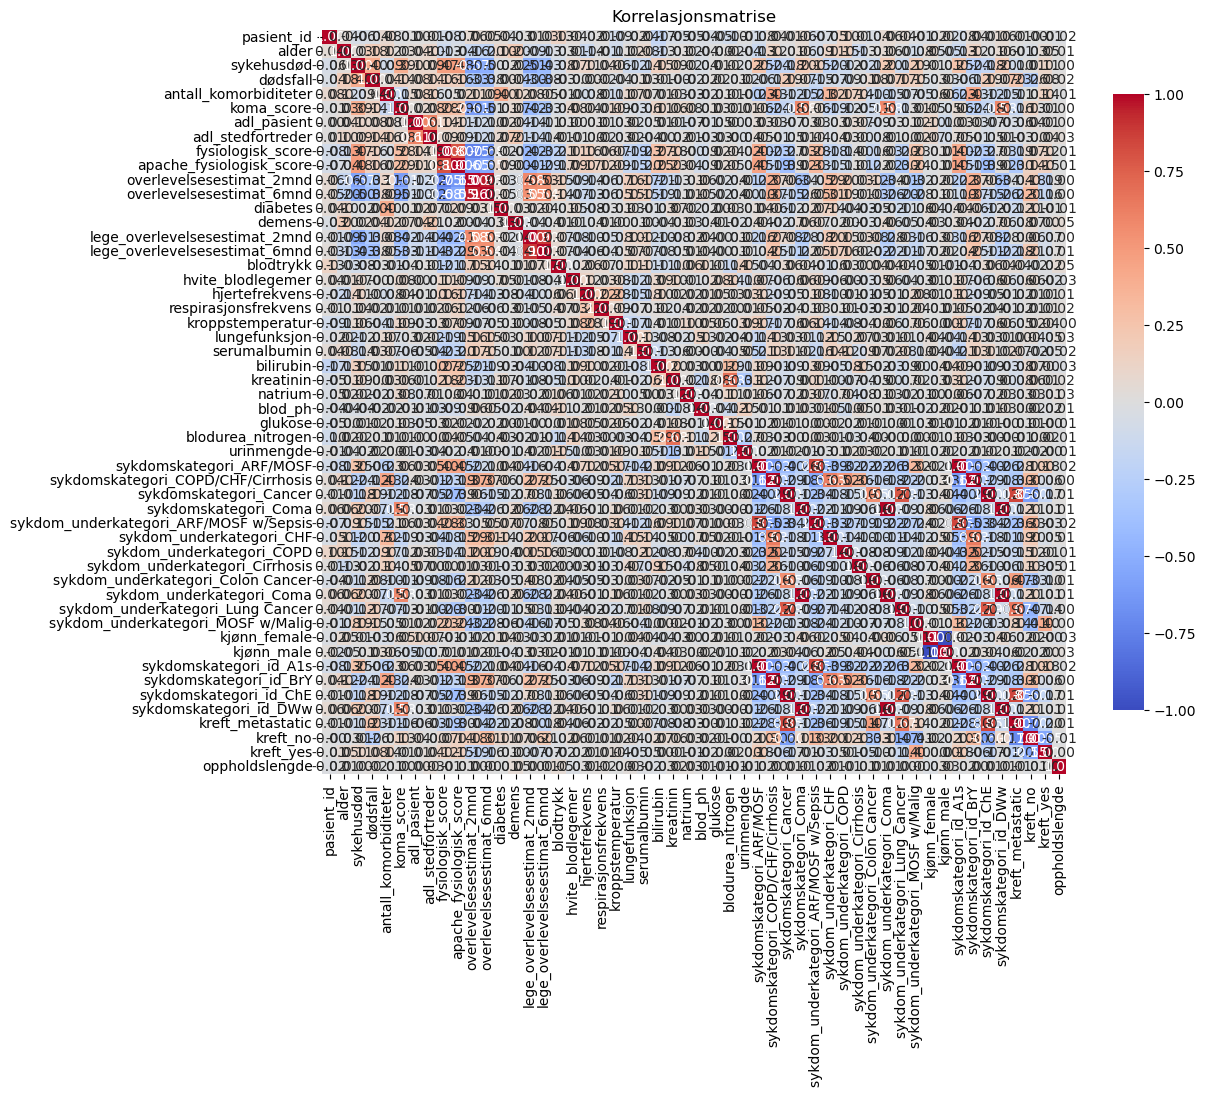

In [30]:
correlation_matrix = df_train.corr()

# Visualiser
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Korrelasjonsmatrise')
plt.show()


### Trening av modeller og Imputering av manglende verdier

In [31]:
#Trener først en baseline modell
baseline = DummyRegressor(strategy="mean")
baseline.fit(X_train, y_train)
rmse_baseline = np.sqrt(mean_squared_error(y_val, np.full_like(y_val, np.mean(y_train))))
rmse_baseline

20.602121584756834

### Ser på en Random forest modell og visualiserer hvilke variabler som er viktigst for predikeringen

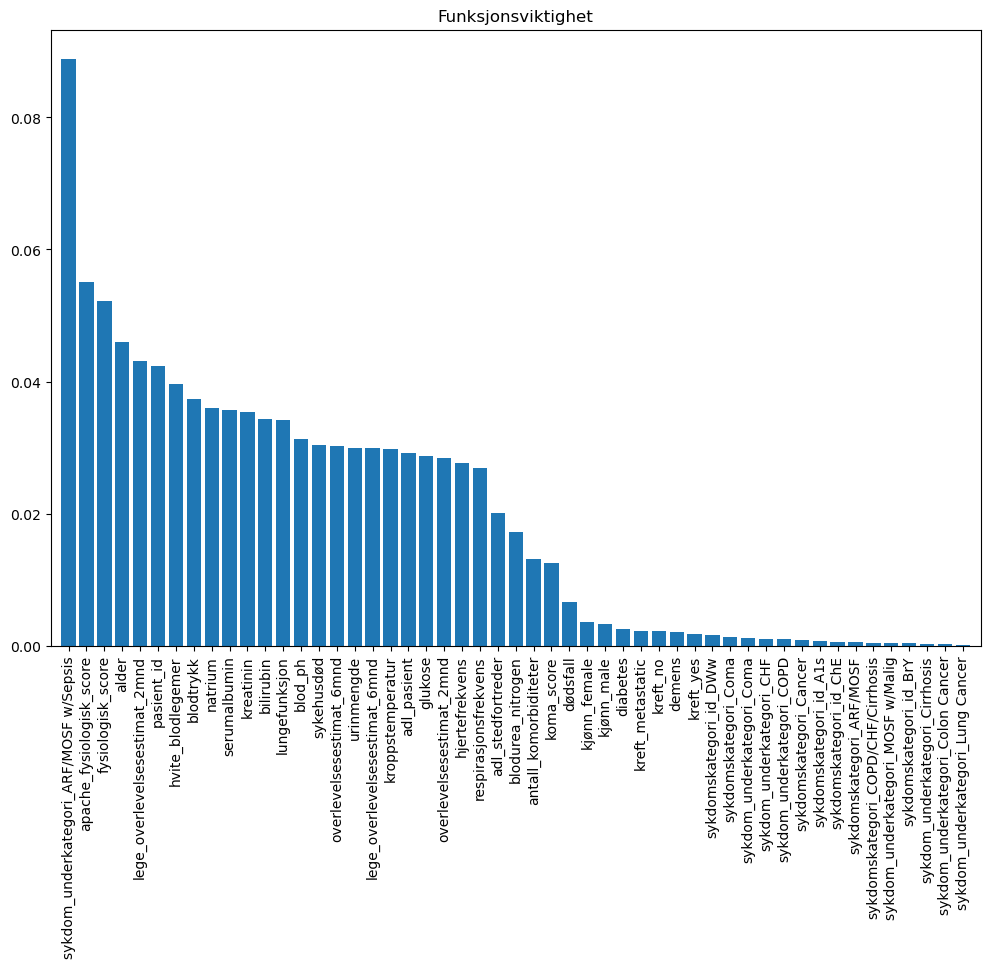

In [32]:
from sklearn.ensemble import RandomForestRegressor

# Tren en Random Forest-modell
X = X_train
y = y_train
model = RandomForestRegressor()
model.fit(X, y)

# Få feature importance
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot
plt.figure(figsize=(12, 8))
plt.title("Funksjonsviktighet")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()


### Imputering av manglende data

In [33]:
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

# Definer Random Forest-modellen
model = RandomForestRegressor()

# Tre ulike imputeringsteknikker:
# 1. Mean Imputation
mean_imputer = SimpleImputer(strategy='mean')

# 2. Median Imputation
median_imputer = SimpleImputer(strategy='median')

# 3. KNN Imputation
knn_imputer = KNNImputer(n_neighbors=5)

# Pipelines for hver strategi
pipelines = {
    'Mean Imputation': Pipeline([('imputer', mean_imputer), ('model', model)]),
    'Median Imputation': Pipeline([('imputer', median_imputer), ('model', model)]),
    'KNN Imputation': Pipeline([('imputer', knn_imputer), ('model', model)])
}

# Sammenlign de ulike imputeringsstrategiene ved bruk av cross-validation
scores = {}
for strategy, pipeline in pipelines.items():
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='r2')  # R^2 score brukes for regresjonsmodeller
    scores[strategy] = np.mean(cv_scores)
    print(f"{strategy} R^2 score: {np.mean(cv_scores):.4f}")

# Finn den beste strategien
best_strategy = max(scores, key=scores.get)
print(f"\nBest imputation strategy: {best_strategy} with R^2 score: {scores[best_strategy]:.4f}")


Mean Imputation R^2 score: 0.1257
Median Imputation R^2 score: 0.1048
KNN Imputation R^2 score: 0.1155

Best imputation strategy: Mean Imputation with R^2 score: 0.1257


### RandomForest og Lineær regresjon med 6 ulike imputeringsstrategier

In [34]:
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error

# Definer modeller
models = {
    "RandomForest": RandomForestRegressor(),
    "LinearRegression": LinearRegression()
}

# Strategier for imputering (inkluderer også fjerning av rader med manglende verdier)
strategies = {
    "Remove": None,  # Fjerner rader med manglende verdier
    "Mean": SimpleImputer(strategy='mean'),
    "Median": SimpleImputer(strategy='median'),
    "KNN_3": KNNImputer(n_neighbors=3),  # KNN med 3 naboer
    "KNN_5": KNNImputer(n_neighbors=5),  # KNN med 5 naboer
    "KNN_7": KNNImputer(n_neighbors=7),  # KNN med 7 naboer
}

# Definer RMSE-scorer
mse_scorer = make_scorer(mean_squared_error)

# Sammenlign strategier for hver modell
for model_name, model in models.items():
    scores = {}
    print(f"\nEvaluating model: {model_name}")

    for strategy_name, imputer in strategies.items():
        
        if strategy_name == "Remove":
            # Fjerner rader med manglende verdier fra både X og y
            X_train_dropped = X_train.dropna()
            y_train_dropped = y_train.loc[X_train_dropped.index]  # Bruker .loc for å synkronisere indekser
            
            # Ingen imputering, bare modellen
            pipeline = Pipeline([('model', model)])  
            cv_scores = cross_val_score(pipeline, X_train_dropped, y_train_dropped, cv=5, scoring=mse_scorer)

        else:
            # Bruker imputering med pipelines
            pipeline = Pipeline([('imputer', imputer), ('model', model)])
            cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring=mse_scorer)
        
        # Lagrer gjennomsnittlig score for hver strategi
        scores[strategy_name] = np.mean(cv_scores)
        print(f"{strategy_name} Mean Squared Error: {np.mean(cv_scores):.4f}")  # Negativ for å gjenspeile scorer

    # Finn den beste strategien for denne modellen (laveste RMSE)
    best_strategy = min(scores, key=scores.get)
    print(f"Best imputation strategy for {model_name}: {best_strategy} with Mean Squared Error: {scores[best_strategy]:.4f}")





Evaluating model: RandomForest
Remove Mean Squared Error: 105.1278
Mean Mean Squared Error: 405.4276
Median Mean Squared Error: 411.9787
KNN_3 Mean Squared Error: 411.2921
KNN_5 Mean Squared Error: 410.0692
KNN_7 Mean Squared Error: 408.2552
Best imputation strategy for RandomForest: Remove with Mean Squared Error: 105.1278

Evaluating model: LinearRegression
Remove Mean Squared Error: 117.0401
Mean Mean Squared Error: 403.5769
Median Mean Squared Error: 403.2007
KNN_3 Mean Squared Error: 403.6314
KNN_5 Mean Squared Error: 403.4857
KNN_7 Mean Squared Error: 403.5123
Best imputation strategy for LinearRegression: Remove with Mean Squared Error: 117.0401


### Mean strategi for imputering ved ulike modeller

In [35]:
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.svm import SVR


# Definer modeller
models = {
    "RandomForest": RandomForestRegressor(),
    "LinearRegression": LinearRegression(),
    "GradientBoosting": GradientBoostingRegressor(),
    "Lasso": LassoCV(),
    "Ridge": RidgeCV(),
    "SVR": SVR(),
}

# Definer imputeringstrategi (bruker gjennomsnittsimputering for enkelhets skyld her)
imputer = SimpleImputer(strategy='mean')

# Evaluering av modeller
mse_scores = {}

for model_name, model in models.items():
    print(f"\nEvaluating model: {model_name}")
    
    # Pipeline med imputering og modell
    pipeline = Pipeline([('imputer', imputer), ('model', model)])
    
    # Tren modellen
    pipeline.fit(X_train, y_train)
    
    # Prediksjon på valideringssettet
    y_pred = pipeline.predict(X_val)
    
    # Beregn MSE
    mse = mean_squared_error(y_val, y_pred)
    mse_scores[model_name] = mse
    print(f"{model_name} Mean Squared Error: {mse:.4f}")

# Finn den beste modellen med lavest MSE
best_model = min(mse_scores, key=mse_scores.get)
print(f"\nBest model: {best_model} with MSE: {mse_scores[best_model]:.4f}")



Evaluating model: RandomForest
RandomForest Mean Squared Error: 382.7378

Evaluating model: LinearRegression
LinearRegression Mean Squared Error: 366.5186

Evaluating model: GradientBoosting
GradientBoosting Mean Squared Error: 357.4711

Evaluating model: Lasso
Lasso Mean Squared Error: 391.8386

Evaluating model: Ridge
Ridge Mean Squared Error: 366.4349

Evaluating model: SVR
SVR Mean Squared Error: 465.5124

Best model: GradientBoosting with MSE: 357.4711


### Ulike modeller med KNN imputering (5 naboer)

In [36]:
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.svm import SVR

# Definer modeller
models = {
    "RandomForest": RandomForestRegressor(),
    "LinearRegression": LinearRegression(),
    "GradientBoosting": GradientBoostingRegressor(),
    "Lasso": LassoCV(),
    "Ridge": RidgeCV(),
    "SVR": SVR(),
}

# Bruker KNN Imputer med 5 nærmeste naboer
imputer = KNNImputer(n_neighbors=5)

# Evaluering av modeller
mse_scores = {}

for model_name, model in models.items():
    print(f"\nEvaluating model: {model_name}")
    
    # Pipeline med imputering (KNN) og modell
    pipeline = Pipeline([('imputer', imputer), ('model', model)])
    
    # Tren modellen
    pipeline.fit(X_train, y_train)
    
    # Prediksjon på valideringssettet
    y_pred = pipeline.predict(X_val)
    
    # Beregn MSE
    mse = mean_squared_error(y_val, y_pred)
    mse_scores[model_name] = mse
    print(f"{model_name} Mean Squared Error: {mse:.4f}")

# Finn den beste modellen med lavest MSE
best_model = min(mse_scores, key=mse_scores.get)
print(f"\nBest model: {best_model} with MSE: {mse_scores[best_model]:.4f}")



Evaluating model: RandomForest
RandomForest Mean Squared Error: 375.4708

Evaluating model: LinearRegression
LinearRegression Mean Squared Error: 367.9061

Evaluating model: GradientBoosting
GradientBoosting Mean Squared Error: 363.6685

Evaluating model: Lasso
Lasso Mean Squared Error: 392.4387

Evaluating model: Ridge
Ridge Mean Squared Error: 367.8276

Evaluating model: SVR
SVR Mean Squared Error: 465.3292

Best model: GradientBoosting with MSE: 363.6685


### Ser på variebler med høy korrelasjon

In [37]:
# Eksempel på å lage et datasett (bruk ditt faktiske datasett)
# df_train = pd.read_csv('path_to_your_data.csv')

# Beregn korrelasjonene med målvariabelen "oppholdslengde"
corr_oppholdslengde = df_train.corr()["oppholdslengde"].sort_values()

# Definer terskelverdi
threshold = 0.02

# Filtrer ut funksjoner som har en korrelasjon større enn terskelen (både positive og negative)
high_corr_features = corr_oppholdslengde[abs(corr_oppholdslengde) > threshold].index.tolist()

# Fjern målvariabelen "oppholdslengde" fra listen
if "oppholdslengde" in high_corr_features:
    high_corr_features.remove("oppholdslengde")

print(f"Variabler med korrelasjon høyere enn {threshold}: {high_corr_features}")

# Lag et nytt datasett med de utvalgte funksjonene
X_selected = df_train[high_corr_features]

Variabler med korrelasjon høyere enn 0.02: ['hvite_blodlegemer', 'kjønn_female', 'bilirubin', 'serumalbumin', 'pasient_id', 'lungefunksjon', 'natrium', 'kjønn_male', 'adl_stedfortreder', 'demens', 'blodtrykk']


##### Ser her at pasient_id og kjønn har høye koreelasjoner som forvirrer modellen, ting som demens er også mulig ikke relevant for oppholdslengde, men modellen finner høy korrelasjon som tyder påå overfitting. At modellene får såpass høy MSE tyder på overfitting og for mye data som forvirrer modellen og imputeringsstrategiene.

### Tester accuracy på ulike modeller og imputeringsstrategier

In [38]:
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

# Definerer ulike imputeringsteknikker
strategies = {
    "Gjennomsnitt": SimpleImputer(missing_values=np.nan, strategy='mean'),
    "KNN": KNNImputer(n_neighbors=5),
    "Median": SimpleImputer(missing_values=np.nan, strategy='median')
}

# Definerer ulike klassifikasjonsmodeller
models = {
    "Logistisk regresjon": LogisticRegression(max_iter=1000),
    "SVM": SVC(),
    "Beslutningstre": DecisionTreeClassifier()
}

# Ordbok for å lagre score
val_scores = {}

# Loop gjennom hver imputeringsteknikk
for strat_name, imputer in strategies.items():
    # Imputer trenings- og valideringsdata
    X_train_imputed = imputer.fit_transform(X_train)
    X_val_imputed = imputer.transform(X_val)
    
    # Sjekk om det finnes NaN etter imputering
    if np.isnan(X_train_imputed).sum() > 0 or np.isnan(X_val_imputed).sum() > 0:
        print(f"Advarsel: Det finnes fortsatt NaN-verdier i {strat_name}-imputeringen.")
    
    # Loop gjennom hver modell
    for model_name, model in models.items():
        # Tren modellen
        model.fit(X_train_imputed, y_train)
        
        # Gjør prediksjon på valideringssettet
        y_pred = model.predict(X_val_imputed)
        
        # Beregn accuracy score
        score = accuracy_score(y_val, y_pred)
        
        # Lagre resultatet
        val_scores[f"{strat_name} + {model_name}"] = score
        print(f"Modell: {model_name} med imputering: {strat_name} -> Accuracy: {score:.3f}")

# Finn den beste modellen basert på valideringsscore
beste_model_name = max(val_scores, key=val_scores.get)
best_score = val_scores[beste_model_name]

print(f"\nDen beste modellen er {beste_model_name} med en accuracy på {best_score:.3f} på valideringssettet.")


/opt/miniconda3/envs/INF161/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Modell: Logistisk regresjon med imputering: Gjennomsnitt -> Accuracy: 0.097
Modell: SVM med imputering: Gjennomsnitt -> Accuracy: 0.080
Modell: Beslutningstre med imputering: Gjennomsnitt -> Accuracy: 0.067


/opt/miniconda3/envs/INF161/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Modell: Logistisk regresjon med imputering: KNN -> Accuracy: 0.092
Modell: SVM med imputering: KNN -> Accuracy: 0.079
Modell: Beslutningstre med imputering: KNN -> Accuracy: 0.069


/opt/miniconda3/envs/INF161/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Modell: Logistisk regresjon med imputering: Median -> Accuracy: 0.087
Modell: SVM med imputering: Median -> Accuracy: 0.082
Modell: Beslutningstre med imputering: Median -> Accuracy: 0.070

Den beste modellen er Gjennomsnitt + Logistisk regresjon med en accuracy på 0.097 på valideringssettet.


In [39]:
from sklearn.preprocessing import StandardScaler

# Definerer imputeringsteknikker som pipeline-steg
imputer_steps = [
    ('gj.snitt', SimpleImputer(missing_values=np.nan, strategy='mean')),
    ('knn', KNNImputer(n_neighbors=5)),
    ('median', SimpleImputer(missing_values=np.nan, strategy='median'))  # Byttet ut konstant med median
]

# Definerer klassifikasjonsmodeller
models = [
    ('logistisk', LogisticRegression(max_iter=1000)),
    ('svm', SVC()),
    ('beslutningstre', DecisionTreeClassifier())
]

# Kombinasjoner av imputering + modell
pipelines = []

for imp_name, imputer in imputer_steps:
    for model_name, model in models:
        pipeline = Pipeline(steps=[
            ('imputer', imputer),   # Imputeringsteknikk
            ('scaler', StandardScaler()),  # Skalerer dataene
            ('model', model)        # Klassifikasjonsmodell
        ])
        pipelines.append((f"{imp_name} + {model_name}", pipeline))

# Tren og evaluer hver pipeline
val_scores = {}

for name, pipeline in pipelines:
    # Tren pipeline på treningsdata
    pipeline.fit(X_train, y_train)
    
    # Evaluer pipeline på valideringsdata
    y_pred = pipeline.predict(X_val)
    score = accuracy_score(y_val, y_pred)
    
    # Lagre score
    val_scores[name] = score
    print(f"Modell: {name} -> Accuracy: {score:.3f}")

# Finn den beste modellen
beste_model_name = max(val_scores, key=val_scores.get)
best_score = val_scores[beste_model_name]

print(f"\nDen beste modellen er {beste_model_name} med en accuracy på {best_score:.3f} på valideringssettet.")


Modell: gj.snitt + logistisk -> Accuracy: 0.090
Modell: gj.snitt + svm -> Accuracy: 0.097
Modell: gj.snitt + beslutningstre -> Accuracy: 0.071
Modell: knn + logistisk -> Accuracy: 0.095
Modell: knn + svm -> Accuracy: 0.104
Modell: knn + beslutningstre -> Accuracy: 0.066
Modell: median + logistisk -> Accuracy: 0.091
Modell: median + svm -> Accuracy: 0.094
Modell: median + beslutningstre -> Accuracy: 0.075

Den beste modellen er knn + svm med en accuracy på 0.104 på valideringssettet.


### Variabelutvinning for forbedring av modeller

In [40]:
X_train.columns

Index(['pasient_id', 'alder', 'sykehusdød', 'dødsfall',
       'antall_komorbiditeter', 'koma_score', 'adl_pasient',
       'adl_stedfortreder', 'fysiologisk_score', 'apache_fysiologisk_score',
       'overlevelsesestimat_2mnd', 'overlevelsesestimat_6mnd', 'diabetes',
       'demens', 'lege_overlevelsesestimat_2mnd',
       'lege_overlevelsesestimat_6mnd', 'blodtrykk', 'hvite_blodlegemer',
       'hjertefrekvens', 'respirasjonsfrekvens', 'kroppstemperatur',
       'lungefunksjon', 'serumalbumin', 'bilirubin', 'kreatinin', 'natrium',
       'blod_ph', 'glukose', 'blodurea_nitrogen', 'urinmengde',
       'sykdomskategori_ARF/MOSF', 'sykdomskategori_COPD/CHF/Cirrhosis',
       'sykdomskategori_Cancer', 'sykdomskategori_Coma',
       'sykdom_underkategori_ARF/MOSF w/Sepsis', 'sykdom_underkategori_CHF',
       'sykdom_underkategori_COPD', 'sykdom_underkategori_Cirrhosis',
       'sykdom_underkategori_Colon Cancer', 'sykdom_underkategori_Coma',
       'sykdom_underkategori_Lung Cancer', 'syk

In [41]:
X_train.head()

,pasient_id,alder,sykehusdød,dødsfall,antall_komorbiditeter,koma_score,adl_pasient,adl_stedfortreder,fysiologisk_score,apache_fysiologisk_score,...,sykdom_underkategori_MOSF w/Malig,kjønn_female,kjønn_male,sykdomskategori_id_A1s,sykdomskategori_id_BrY,sykdomskategori_id_ChE,sykdomskategori_id_DWw,kreft_metastatic,kreft_no,kreft_yes
6972,8203,74.12500,0,1,3,0.0,None,0.0,21.097656,17.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
5124,6018,65.26495,1,1,5,44.0,None,0.0,46.898438,71.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
7266,8556,71.98395,0,1,3,0.0,None,0.0,20.398438,26.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3687,4320,52.26599,0,0,1,0.0,None,0.0,37.195312,22.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
7579,8922,69.77100,0,0,1,0.0,0.0,0.0,5.599609,9.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


In [42]:
X_train.isna().sum()

pasient_id                                   0
alder                                        0
sykehusdød                                   0
dødsfall                                     0
antall_komorbiditeter                        0
koma_score                                   0
adl_pasient                               3403
adl_stedfortreder                         1714
fysiologisk_score                            0
apache_fysiologisk_score                     0
overlevelsesestimat_2mnd                     0
overlevelsesestimat_6mnd                     0
diabetes                                     0
demens                                       0
lege_overlevelsesestimat_2mnd              984
lege_overlevelsesestimat_6mnd              972
blodtrykk                                    0
hvite_blodlegemer                          132
hjertefrekvens                               0
respirasjonsfrekvens                         0
kroppstemperatur                             0
lungefunksjon

### Lager nye variabler og fjerner unødvendige

In [43]:
X_train['kreft'] = X_train['kreft_yes']
X_train = X_train.drop(columns=['kreft_yes', 'kreft_no'])
X_train['hjertefrekvens_høy'] = (X_train['hjertefrekvens'] > 100).astype(int)
X_train['hjertefrekvens_respirasjonsfrekvens'] = (X_train['hjertefrekvens'] * X_train['respirasjonsfrekvens'])
X_train['total_sykdomsbelastning'] = (
    X_train['sykdomskategori_Cancer'] + 
    X_train['sykdomskategori_ARF/MOSF'] + 
    X_train['sykdomskategori_COPD/CHF/Cirrhosis']
)

X_val['kreft'] = X_val['kreft_yes']
X_val = X_val.drop(columns=['kreft_yes', 'kreft_no'])
X_val['hjertefrekvens_høy'] = (X_val['hjertefrekvens'] > 100).astype(int)
X_val['hjertefrekvens_respirasjonsfrekvens'] = (X_val['hjertefrekvens'] * X_val['respirasjonsfrekvens'])
X_val['total_sykdomsbelastning'] = (
    X_val['sykdomskategori_Cancer'] + 
    X_val['sykdomskategori_ARF/MOSF'] + 
    X_val['sykdomskategori_COPD/CHF/Cirrhosis']
)



In [44]:
X_train.head()

,pasient_id,alder,sykehusdød,dødsfall,antall_komorbiditeter,koma_score,adl_pasient,adl_stedfortreder,fysiologisk_score,apache_fysiologisk_score,...,kjønn_male,sykdomskategori_id_A1s,sykdomskategori_id_BrY,sykdomskategori_id_ChE,sykdomskategori_id_DWw,kreft_metastatic,kreft,hjertefrekvens_høy,hjertefrekvens_respirasjonsfrekvens,total_sykdomsbelastning
6972,8203,74.12500,0,1,3,0.0,None,0.0,21.097656,17.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0,1440.0,1.0
5124,6018,65.26495,1,1,5,44.0,None,0.0,46.898438,71.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1,6080.0,1.0
7266,8556,71.98395,0,1,3,0.0,None,0.0,20.398438,26.0,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0,1628.0,1.0
3687,4320,52.26599,0,0,1,0.0,None,0.0,37.195312,22.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0,1200.0,1.0
7579,8922,69.77100,0,0,1,0.0,0.0,0.0,5.599609,9.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1,6600.0,1.0


In [48]:
from sklearn.preprocessing import StandardScaler

# Definerer imputeringsteknikker som pipeline-steg
imputer_steps = [
    ('gj.snitt', SimpleImputer(missing_values=np.nan, strategy='mean')),
    ('knn', KNNImputer(n_neighbors=5)),
    ('median', SimpleImputer(missing_values=np.nan, strategy='median'))  # Byttet ut konstant med median
]

# Definerer klassifikasjonsmodeller
models = [
    ('logistisk', LogisticRegression(max_iter=1000)),
    ('svm', SVC()),
    ('beslutningstre', DecisionTreeClassifier())
]

# Kombinasjoner av imputering + modell
pipelines = []

for imp_name, imputer in imputer_steps:
    for model_name, model in models:
        pipeline = Pipeline(steps=[
            ('imputer', imputer),   # Imputeringsteknikk
            ('scaler', StandardScaler()),  # Skalerer dataene
            ('model', model)        # Klassifikasjonsmodell
        ])
        pipelines.append((f"{imp_name} + {model_name}", pipeline))

# Tren og evaluer hver pipeline
val_scores = {}

for name, pipeline in pipelines:
    # Tren pipeline på treningsdata
    pipeline.fit(X_train, y_train)
    
    # Evaluer pipeline på valideringsdata
    y_pred = pipeline.predict(X_val)
    score = accuracy_score(y_val, y_pred)
    
    # Lagre score
    val_scores[name] = score
    print(f"Modell: {name} -> Accuracy: {score:.3f}")

# Finn den beste modellen
beste_model_name = max(val_scores, key=val_scores.get)
best_score = val_scores[beste_model_name]

print(f"\nDen beste modellen er {beste_model_name} med en accuracy på {best_score:.3f} på valideringssettet.")

Modell: gj.snitt + logistisk -> Accuracy: 0.079
Modell: gj.snitt + svm -> Accuracy: 0.095
Modell: gj.snitt + beslutningstre -> Accuracy: 0.063
Modell: knn + logistisk -> Accuracy: 0.080
Modell: knn + svm -> Accuracy: 0.088
Modell: knn + beslutningstre -> Accuracy: 0.069
Modell: median + logistisk -> Accuracy: 0.082
Modell: median + svm -> Accuracy: 0.089
Modell: median + beslutningstre -> Accuracy: 0.073

Den beste modellen er gj.snitt + svm med en accuracy på 0.095 på valideringssettet.


In [50]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Definerer klassifikasjonsmodeller
models = [
    ('Logistisk Regresjon', LogisticRegression(max_iter=1000)),
    ('SVM', SVC()),
    ('Beslutningstre', DecisionTreeClassifier()),
    ('Random Forest', RandomForestClassifier()),
    ('Gradient Boosting', GradientBoostingClassifier())
]

# Ordbok for å lagre score
val_scores = {}

# Loop gjennom hver modell
for model_name, model in models:
    # Fjern rader med NaN fra treningsdata
    X_train_clean = X_train.dropna()
    y_train_clean = y_train.loc[X_train_clean.index]  # Sørg for at y er synkronisert med X

    # Lag en pipeline for treningsdata
    pipeline = Pipeline(steps=[
        ('scaler', StandardScaler()),  # Skalerer dataene
        ('model', model)               # Klassifikasjonsmodell
    ])

    # Tren modellen
    pipeline.fit(X_train_clean, y_train_clean)

    # Evaluer på valideringssettet
    X_val_clean = X_val.dropna()  # Fjern NaN fra valideringssettet
    y_val_clean = y_val.loc[X_val_clean.index]  # Sørg for at y er synkronisert med X

    # Forutsi og beregn accuracy
    y_pred = pipeline.predict(X_val_clean)
    score = accuracy_score(y_val_clean, y_pred)

    # Lagre score
    val_scores[model_name] = score
    print(f"Modell: {model_name} med remove-strategi -> Accuracy: {score:.3f}")

# Finn den beste modellen
beste_model_name = max(val_scores, key=val_scores.get)
best_score = val_scores[beste_model_name]

print(f"\nDen beste modellen med remove-strategi er {beste_model_name} med en accuracy på {best_score:.3f} på valideringssettet.")



Modell: Logistisk Regresjon med remove-strategi -> Accuracy: 0.137
Modell: SVM med remove-strategi -> Accuracy: 0.078
Modell: Beslutningstre med remove-strategi -> Accuracy: 0.137
Modell: Random Forest med remove-strategi -> Accuracy: 0.098
Modell: Gradient Boosting med remove-strategi -> Accuracy: 0.078

Den beste modellen med remove-strategi er Logistisk Regresjon med en accuracy på 0.137 på valideringssettet.


### Sjekker om imputeringen har blitt forbedret etter variabelutvinning

In [46]:
models = {
    "RandomForest": RandomForestRegressor(),
    "LinearRegression": LinearRegression()
}

# Strategier for imputering (inkluderer også fjerning av rader med manglende verdier)
strategies = {
    "Remove": None,  # Fjerner rader med manglende verdier
    "Mean": SimpleImputer(strategy='mean'),
    "Median": SimpleImputer(strategy='median'),
    "KNN_3": KNNImputer(n_neighbors=3),  # KNN med 3 naboer
    "KNN_5": KNNImputer(n_neighbors=5),  # KNN med 5 naboer
}

# Definer RMSE-scorer
mse_scorer = make_scorer(mean_squared_error)

# Sammenlign strategier for hver modell
for model_name, model in models.items():
    scores = {}
    print(f"\nEvaluating model: {model_name}")

    for strategy_name, imputer in strategies.items():
        
        if strategy_name == "Remove":
            # Fjerner rader med manglende verdier fra både X og y
            X_train_dropped = X_train.dropna()
            y_train_dropped = y_train.loc[X_train_dropped.index]  # Bruker .loc for å synkronisere indekser
            
            # Ingen imputering, bare modellen
            pipeline = Pipeline([('model', model)])  
            cv_scores = cross_val_score(pipeline, X_train_dropped, y_train_dropped, cv=5, scoring=mse_scorer)

        else:
            # Bruker imputering med pipelines
            pipeline = Pipeline([('imputer', imputer), ('model', model)])
            cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring=mse_scorer)
        
        # Lagrer gjennomsnittlig score for hver strategi
        scores[strategy_name] = np.mean(cv_scores)
        print(f"{strategy_name} Mean Squared Error: {np.mean(cv_scores):.4f}")  # Negativ for å gjenspeile scorer

    # Finn den beste strategien for denne modellen (laveste RMSE)
    best_strategy = min(scores, key=scores.get)
    print(f"Best imputation strategy for {model_name}: {best_strategy} with Mean Squared Error: {scores[best_strategy]:.4f}")


Evaluating model: RandomForest
Remove Mean Squared Error: 103.9912
Mean Mean Squared Error: 404.4733
Median Mean Squared Error: 413.8567
KNN_3 Mean Squared Error: 412.8798
KNN_5 Mean Squared Error: 410.8440
Best imputation strategy for RandomForest: Remove with Mean Squared Error: 103.9912

Evaluating model: LinearRegression
Remove Mean Squared Error: 118.0806
Mean Mean Squared Error: 403.3129
Median Mean Squared Error: 402.9467
KNN_3 Mean Squared Error: 403.4386
KNN_5 Mean Squared Error: 403.3218
Best imputation strategy for LinearRegression: Remove with Mean Squared Error: 118.0806
